# **STRYKER HACKATHON**
### Problem Statement 03 - Surgical Tool Segmentation

> Ojas Patil (21BAI1106)

> Garvita Kesarwani (21BCE1086)


## Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cloning the Detectron2 Repo

In [2]:
!python -m pip install pyyaml==5.1 >/dev/null 2>&1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2' >/dev/null 2>&1
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])} >/dev/null 2>&1
sys.path.insert(0, os.path.abspath('./detectron2'))

## Importing the required libraries

In [24]:
# Some basic setup
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt

### Info about NVIDIA and CUDA version

In [25]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


### Lets view a sample image

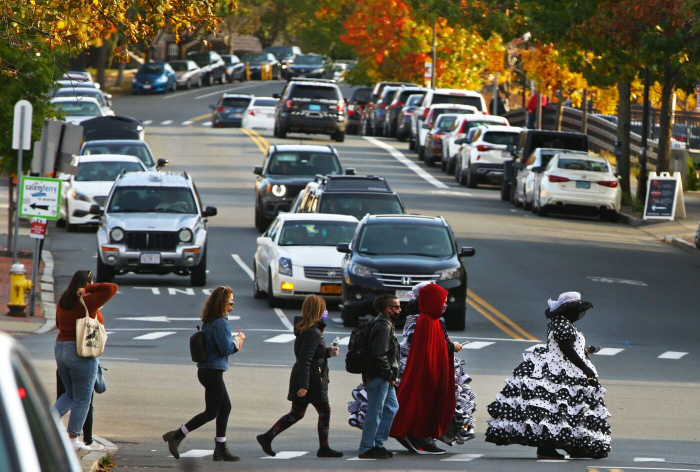

In [52]:
im = cv2.imread("/content/drive/MyDrive/Strykathon/detectron_test.jpg")

# scaling down image for visualization
scale_percent = 50
width = int(im.shape[1] * scale_percent / 100)
height = int(im.shape[0] * scale_percent / 100)
im = cv2.resize(im, (width, height), interpolation=cv2.INTER_AREA)

cv2_imshow(im)

### Importing the Segemntation model from Detectron2 model zoo

In [53]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# set threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[04/13 03:41:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [54]:
# look at the outputs - tensors and bounding boxes.
print(outputs["instances"].pred_classes)
outputs["instances"].remove("pred_boxes")
# print(outputs["instances"].pred_boxes)

# if we wish to remove labels also
# outputs["instances"].remove("pred_classes")

tensor([ 0,  0,  0,  0,  0,  2,  2, 26,  2,  2,  2,  2,  2,  2,  2, 24,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 24, 10,  2,  2,  2,  0,  2,
         2], device='cuda:0')


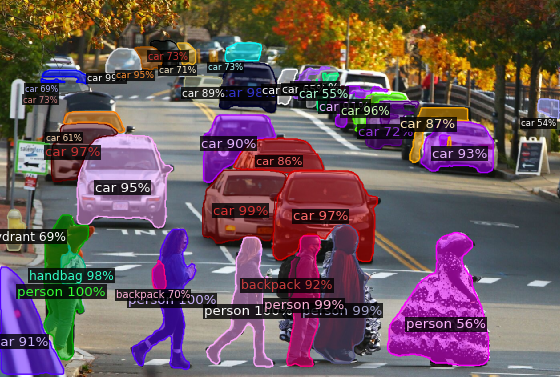

In [55]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

### Sample Image from Surgical Tools Dataset

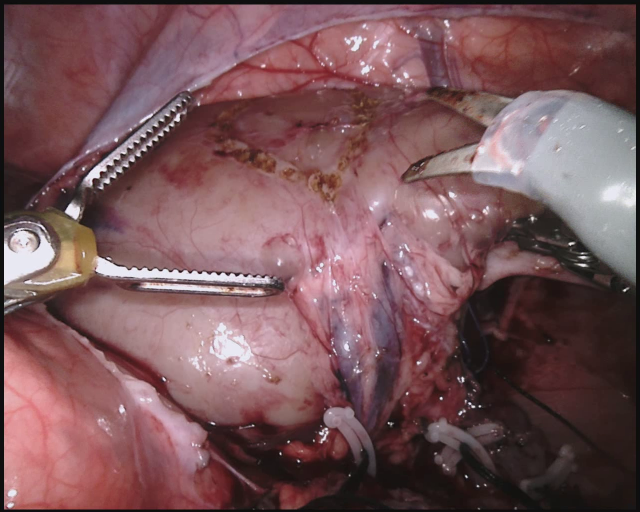

In [56]:
sci_im = cv2.imread("/content/drive/MyDrive/Strykathon/frame024.png")

# scaling down image for visualization
scale_percent = 50
width = int(sci_im.shape[1] * scale_percent / 100)
height = int(sci_im.shape[0] * scale_percent / 100)
sci_im = cv2.resize(sci_im, (width, height), interpolation=cv2.INTER_AREA)

cv2_imshow(sci_im)

### Predictions using pre-trained Detectron2 Model

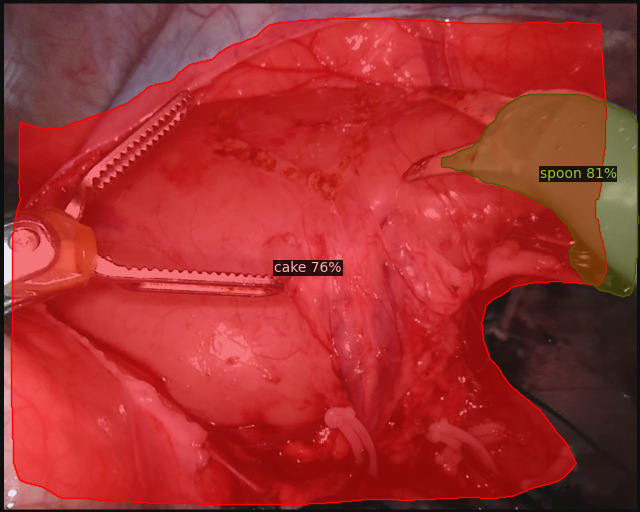

In [57]:
sci_outputs = predictor(sci_im)
sci_outputs["instances"].remove("pred_boxes")
sci_v = Visualizer(sci_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
sci_out = sci_v.draw_instance_predictions(sci_outputs["instances"].to("cpu"))
cv2_imshow(sci_out.get_image()[:, :, ::-1])

#### We can infer that Detectron2 has been trained on a dataset which does not consist of classes required for our use case. Thus, we will need to fine-tune the Detectron2 Model using our custom dataset

In [58]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_train1", {}, "/content/drive/MyDrive/Strykathon/train/train_json.json", "/content/drive/MyDrive/Strykathon/train")
register_coco_instances("my_dataset_val1", {}, "/content/drive/MyDrive/Strykathon/test/test_json.json", "/content/drive/MyDrive/Strykathon/test")

In [59]:
train_metadata = MetadataCatalog.get("my_dataset_train1")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train1")

[04/13 03:43:59 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Strykathon/train/train_json.json takes 1.11 seconds.
[04/13 03:43:59 d2.data.datasets.coco]: Loaded 27 images in COCO format from /content/drive/MyDrive/Strykathon/train/train_json.json


In [60]:
val_metadata = MetadataCatalog.get("my_dataset_val1")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val1")

[04/13 03:44:00 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Strykathon/test/test_json.json takes 1.52 seconds.
[04/13 03:44:00 d2.data.datasets.coco]: Loaded 8 images in COCO format from /content/drive/MyDrive/Strykathon/test/test_json.json


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Good_model"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train1",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7  # We have 7 classes.

# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[04/12 18:38:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [ ]:
trainer.train() #Start the training process

[04/12 18:38:22 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[04/12 18:38:34 d2.utils.events]:  eta: 1:18:18  iter: 19  total_loss: 4.285  loss_cls: 2.167  loss_box_reg: 0.8884  loss_mask: 0.6919  loss_rpn_cls: 0.3992  loss_rpn_loc: 0.1226    time: 0.4583  last_time: 0.5101  data_time: 0.0452  last_data_time: 0.0208   lr: 4.9953e-06  max_mem: 2322M
[04/12 18:38:47 d2.utils.events]:  eta: 1:15:33  iter: 39  total_loss: 4.104  loss_cls: 2.057  loss_box_reg: 0.8688  loss_mask: 0.6888  loss_rpn_cls: 0.2767  loss_rpn_loc: 0.1412    time: 0.4537  last_time: 0.3815  data_time: 0.0065  last_data_time: 0.0075   lr: 9.9902e-06  max_mem: 2323M
[04/12 18:38:56 d2.utils.events]:  eta: 1:15:27  iter: 59  total_loss: 3.843  loss_cls: 1.805  loss_box_reg: 0.9133  loss_mask: 0.6838  loss_rpn_cls: 0.3548  loss_rpn_loc: 0.1192    time: 0.4592  last_time: 0.4644  data_time: 0.0098  last_data_time: 0.0068   lr: 1.4985e-05  max_mem: 2323M
[04/12 18:39:06 d2.utils.events]:  eta: 1:15:28  iter: 79  total_loss: 3.358  loss_cls: 1.488  loss_box_reg: 0.8762  loss_mask: 0.

In [ ]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Good_model/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[04/12 20:08:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ColabNotebooks/models/Detectron2_Good_model/model_final.pth ...


In [63]:
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/Strykathon/config.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Strykathon/model_final.pth"
predictor = DefaultPredictor(cfg)

[04/13 03:44:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Strykathon/model_final.pth ...


### Predictions on Validation Data

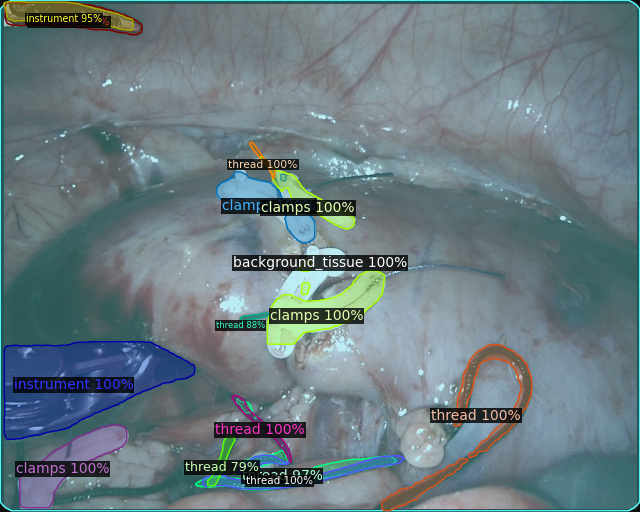

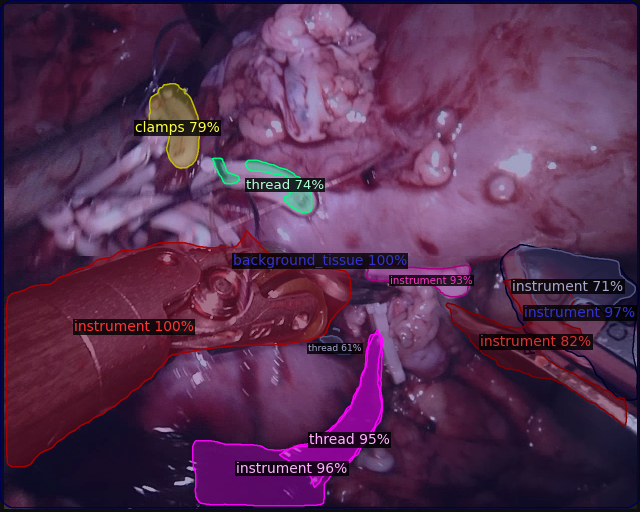

In [64]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 2):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    outputs["instances"].remove("pred_boxes")
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

### As suggested, we have removed the bounding boxes which allows us to more clearly visualize the labels and segmentation

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("my_dataset_val1", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val1")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[04/13 02:15:44 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[04/13 02:15:44 d2.data.datasets.coco]: Loaded 8 images in COCO format from /content/drive/MyDrive/Strykathon/test/test_json.json
[04/13 02:15:44 d2.data.build]: Distribution of instances among all 7 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| background_.. | 8            |  instrument   | 21           |    thread     | 36           |
|    clamps     | 24           | suturing_ne.. | 2            | suction_ins.. | 3            |
| ultrasound_.. | 0            |               |              |               |              |
|     total     | 94           |               |              |               |              |
[04/13 02:15:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortest

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[04/13 02:15:47 d2.evaluation.evaluator]: Total inference time: 0:00:01.124081 (0.374694 s / iter per device, on 1 devices)
[04/13 02:15:47 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.098398 s / iter per device, on 1 devices)
[04/13 02:15:47 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/13 02:15:47 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[04/13 02:15:47 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.313
 Average